# TMD Model - Contour Plots

From Javey 2019 Science Paper

Note: something doesn't seem right about parameters given, seems impossible to reproduce WSe2 curves from paper given their parameters. N is only free parameter; the ratios of the rates don't quite work out right.

Initial stuff

In [4]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.optimize import fsolve

np.seterr(divide = 'ignore') ;

Add my plot style in

In [5]:
plt.style.use(['presplot_small'])

TMD parameters

In [6]:
labels=['txr','txnr','ttr_n','ttnr_n','ttr_p','ttnr_p','T_n','T_p','Cbx']
tmds=['MoS_2','WS_2','MoSe_2','WSe_2']
params=np.zeros((4,np.size(labels)))
#mos2=[8,np.inf,0.11,0.05,np.inf,np.inf,2e-11,0.0,3.5] #original
mos2=[8,np.inf,0.11,0.005,np.inf,np.inf,1.5e-13,0.0,3.5]
ws2=[2,np.inf,0.032,0.1,np.inf,np.inf,5e-12,0.0,2.4]
mose2=[80,26.7,4.4,0.066,50,50,3e-12,1e-10,0.03]
wse2=[16.7,1.9,0.33,0.033,1,1,2.5e-11,3.5e-10,0.06]
#wse2=[16.7,1.9,0.33,0.033,1,1e3,2.5e-11,3.5e-10,0.06]
params[0,:]=mos2
params[1,:]=ws2
params[2,:]=mose2
params[3,:]=wse2
all_plqy={}

Constants

In [7]:
k=1.381e-23 #J/K
t=300 #K
h=6.626e-34 #J/s
hbar=h/(2*np.pi)
m0=9.109e-31 #kg
q=1.602e-19 #coulombs
c=2.998e8 #m/s
eps0=8.85e-12 #F/m

### Intialization

Set TMD and Voltage, load PLQY data, set PLQY0 for N extraction

In [8]:
tmd=0

size=[5.5,4.25]
#size=[3.5,3.5]

#arrays
gs=np.logspace(15, 21, 100)
Vs=np.arange(-20,21,1)
plqys=np.zeros((np.size(gs),np.size(Vs)))

TMD parameters

In [9]:
#easier than making a dictionary - don't want to type in d every time
txr=params[tmd,0]*1e-9 #s
txnr=params[tmd,1]*1e-9 #s
ttr_n=params[tmd,2]*1e-6 #s - for some reason was reported in µs
ttnr_n=params[tmd,3]*1e-9 #s
ttr_p=params[tmd,4]*1e-6 #s - same as above
ttnr_p=params[tmd,5]*1e-9 #s
T_n=params[tmd,6]
T_p=params[tmd,7]
Cbx=params[tmd,8]

#calculate total lifetimes for each quasiparticle
tx=1/(1/txnr+1/txr)
tt_n=1/(1/ttnr_n+1/ttr_n)
tt_p=1/(1/ttnr_p+1/ttr_p)

#bandgap and threshhold voltage
if tmd==0:
    #Vth=-20 #original
    Vth=-15
    Eg=1.8
    me=0.51*m0
    mh=0.54*m0

elif tmd==1:
    Vth=-20
    Eg=2.1
    me=0.35*m0
    mh=0.34*m0

elif tmd==2:
    #Vth=-5
    Vth=-4
    Eg=1.5
    me=0.50*m0
    mh=0.58*m0
    
elif tmd==3:
    Vth=0
    #Vth=-0.005
    Eg=1.7
    me=0.35*m0
    mh=0.35*m0

#for initial N, P guesses
Cox=1/(1/(3.8*eps0*1e-2/50e-7)+1/(2*eps0*1e-2/100e-7)) #50 nm oxide=50e-7 cm; 8.85e-12F/m=8.85e-14F/cm
gc2d=me/(np.pi*hbar**2)*1/(100**2) #1/cm^2*energy
gv2d=mh/(np.pi*hbar**2)*1/(100**2) #1/cm^2*energy
ni=(gc2d*gv2d)**0.5*(k*t)*np.exp(-q*Eg/(2*k*t))

#new calculation of T_n, T_p
mt_n=2*me+mh
mt_p=me+2*mh
mx=me+mh
Et=0.03 #eV
T_n=np.pi*hbar**2/(k*t)*mt_n/(me*mx)*np.exp(-q*Et/(k*t))*1e4
T_p=np.pi*hbar**2/(k*t)*mt_p/(me*mx)*np.exp(-q*Et/(k*t))*1e4

Loop over voltages and generation rates

In [10]:
j=0
for V in Vs:
    
    #Solve for initial N, P concentrations
    N0P0=np.abs(Cox/q*(V-Vth))

    if V>Vth: #then we are electron doping, ef towards CB
        NPguess=[N0P0,ni**2/N0P0]

    elif V<Vth: #then we are hole doping, ef towards VB
        NPguess=[ni**2/N0P0,N0P0]

    elif V==Vth:
        NPguess=[ni,ni]


    def NPfunc(y):
        #x[0]=N, x[1]=P

        #net charged carriers
        out = [Cox*(V-Vth)/q-(y[0]-y[1])]

        #2D mass action law. Modified becuase of v small & v big numbers!

        if NPguess[0]>0.01*gc2d*k*t: #N is large, P is very small – Taylor expand for P portion
            out.append(gc2d*k*t*(np.exp(y[0]/(gc2d*k*t))-1)*y[1]-ni**2)

        elif NPguess[1]>0.01*gv2d*k*t: #P is large, N is very small – Taylor expand for N portion
            out.append(y[0]*gv2d*k*t*(np.exp(y[1]/(gv2d*k*t))-1)-ni**2)

        else: #not degenerately doped
            out.append(y[0]*y[1]-ni**2)      

        return out

    y0, infodict, ier, mesg = fsolve(NPfunc, NPguess, full_output=True)           

    N=y0[0]
    P=y0[1]
    
    #Solve polynomial equations to get carrier concentrations at all G values
    i=0
    for g in gs:     
        #solve for nx, rx
        #poly_nx=np.poly1d([Cbx*T_p*T_n*Cbx*T_n,Cbx+T_n/tx,1/tx+N*T_n/tt_n-g*T_n,-g])
        poly_nx=np.poly1d([Cbx*T_p*T_n,Cbx*(T_n+T_p)+T_n*T_p/tx,
                            Cbx+T_n*T_p*(-g+P/tt_p+N/tt_n)+(T_n+T_p)/tx,  
                           1/tx+N*T_n/tt_n+P*T_p/tt_p-g*(T_n+T_p),-g])
        roots=poly_nx.r
        nx=np.real(roots[np.logical_and(np.isreal(roots),roots>0)])
        rxr=nx/txr
        rxnr=nx/txnr

        #solve for ne
        ne=N/(1+T_n*nx)+P/(1+T_p*nx)

        #solve for nt
        nt_n=T_n*nx*N/(1+T_n*nx)
        nt_p=T_p*nx*P/(1+T_p*nx)
        nt=nt_n+nt_p

        #plqy
        plqy=1/g*(nx/txr+nt_n/ttr_n+nt_p/ttr_p)

        plqys[i,j]=plqy

        i+=1
    
    j+=1

Plot PLQY

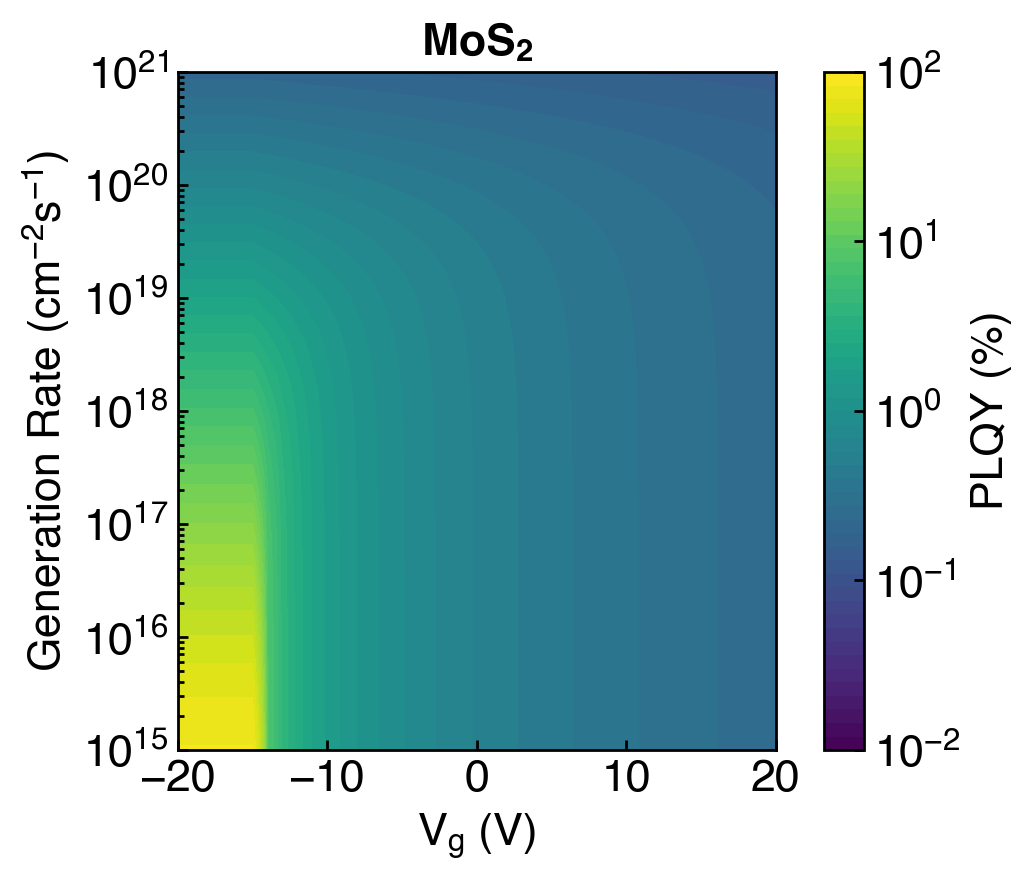

In [11]:
mylevels=np.logspace(-4,0,51)*1e2

fig,ax=plt.subplots()
cplot=ax.contourf(Vs,gs,plqys*1e2,levels=mylevels,locator=ticker.LogLocator())
ax.set_yscale('log')
ax.set_xlabel('$V_g$ (V)')
ax.set_ylabel('Generation Rate ($cm^{-2}s^{-1}$)')
ax.set_title('$'+tmds[tmd]+'$')
cbar = fig.colorbar(cplot,ticks=[100,10,1,0.1,0.01],label='PLQY (%)')

plt.show()
fig.savefig('figures/contours/'+tmds[tmd]+'_plqy.png')

Plot one slice of this plot

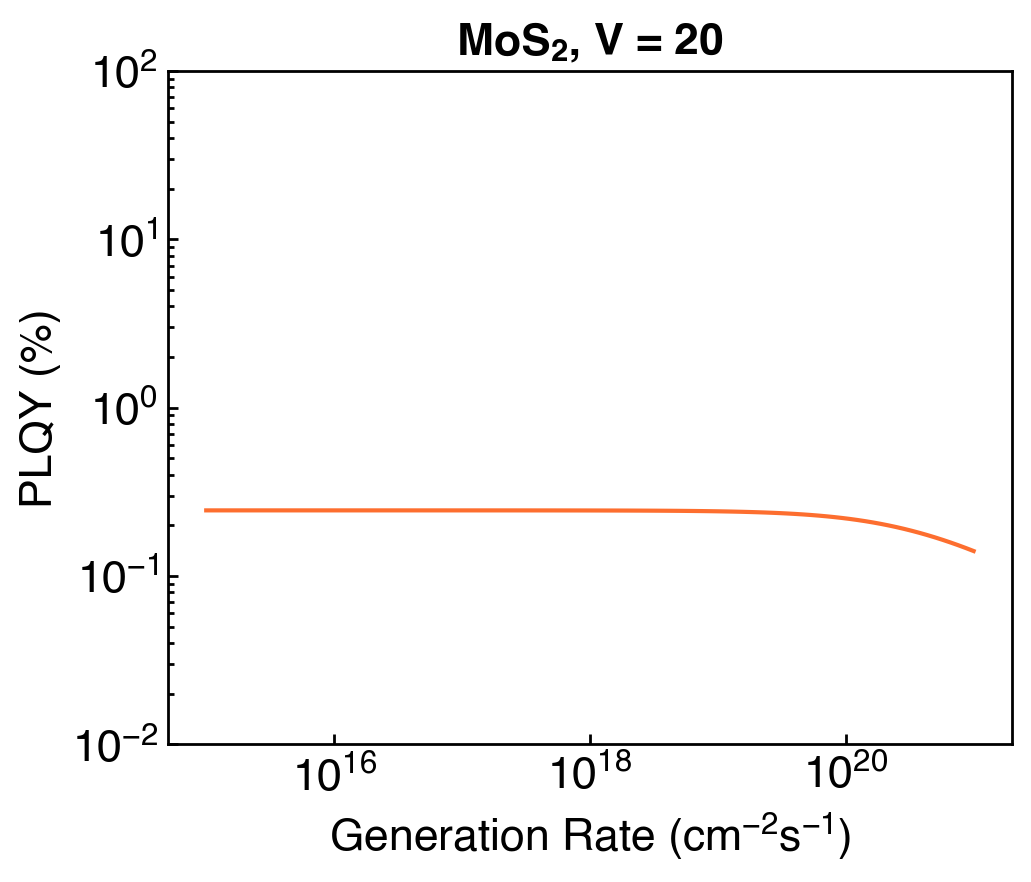

In [12]:
Vplot=20
iplot=np.where(Vs==Vplot)[0][0]

fig,ax=plt.subplots()
ax.loglog(gs,plqys[:,iplot]*1e2)
ax.set_xlabel('Generation Rate ($cm^{-2}s^{-1}$)')
ax.set_ylabel('PLQY (%)')
ax.set_ylim([1e-2,1e2])
ax.set_title('$'+tmds[tmd]+'$, V = '+str(Vs[iplot]))
fig.savefig('figures/contours/'+tmds[tmd]+'_'+str(Vs[iplot])+'V.png')

### Trion binding energy

In [55]:
#Largest possible value:

me=0.3*m0
mh=0.3*m0

Et=0.03 #trion binding energy, eV
mt=2*me+mh
mx=me+mh

T_n_test=np.pi*hbar**2/(k*t)*mt/(me*mx)*np.exp(q*Et/(k*t))*1e4
T_n_test

1.476629519356824e-12

In [57]:
Et=0.2
T_n_javey=2*(2*me/m0+mh/m0)/(4*k*t*me/m0*(me/m0+mh/m0)) #*np.exp(-0.03/(25))*1e4
T_n_javey_2=np.pi*hbar**2/(2*k*t)*mt/(me*mx)*np.exp(q*Et/(k*t))*1e4
T_n_javey_2

5.285367947188869e-10